In [42]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap 


from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap 
import lightgbm as lgb

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap 
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap 
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder

In [43]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [61]:
#data
train=pd.read_csv("/u/spa-d4/grad/mfe261/Projects/PREPARE/dataset/train_features.csv")
y=pd.read_csv("/u/spa-d4/grad/mfe261/Projects/PREPARE/dataset/train_labels.csv")
test=pd.read_csv("/u/spa-d4/grad/mfe261/Projects/PREPARE/dataset/test_features.csv")
test_ground_truth=pd.read_csv("/u/spa-d4/grad/mfe261/Projects/PREPARE/dataset/sdoh_test_labels.csv")

#let merge train and label
main_df = pd.merge(train, y, on='uid', how='left')

#lets merged test AND sample submission
test_df = pd.merge(test, test_ground_truth, on='uid', how='left')

y=main_df['composite_score']
y_test=test_df['composite_score']
data=pd.concat((main_df,test_df)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score', 'uid'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    data[col] = pd.Categorical(data[col].fillna("Missing"))
    
#separate train and test
main_df=data[:len(main_df)]
test_df=data[len(main_df):]

/tmp/ipykernel_155778/145228375.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_155778/145228375.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_155778/145228375.py:13: FutureWarning: Downcasting behavior in `rep

## LighGBoost ##

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 4338, number of used features: 193
[LightGBM] [Info] Start training from score 157.040341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

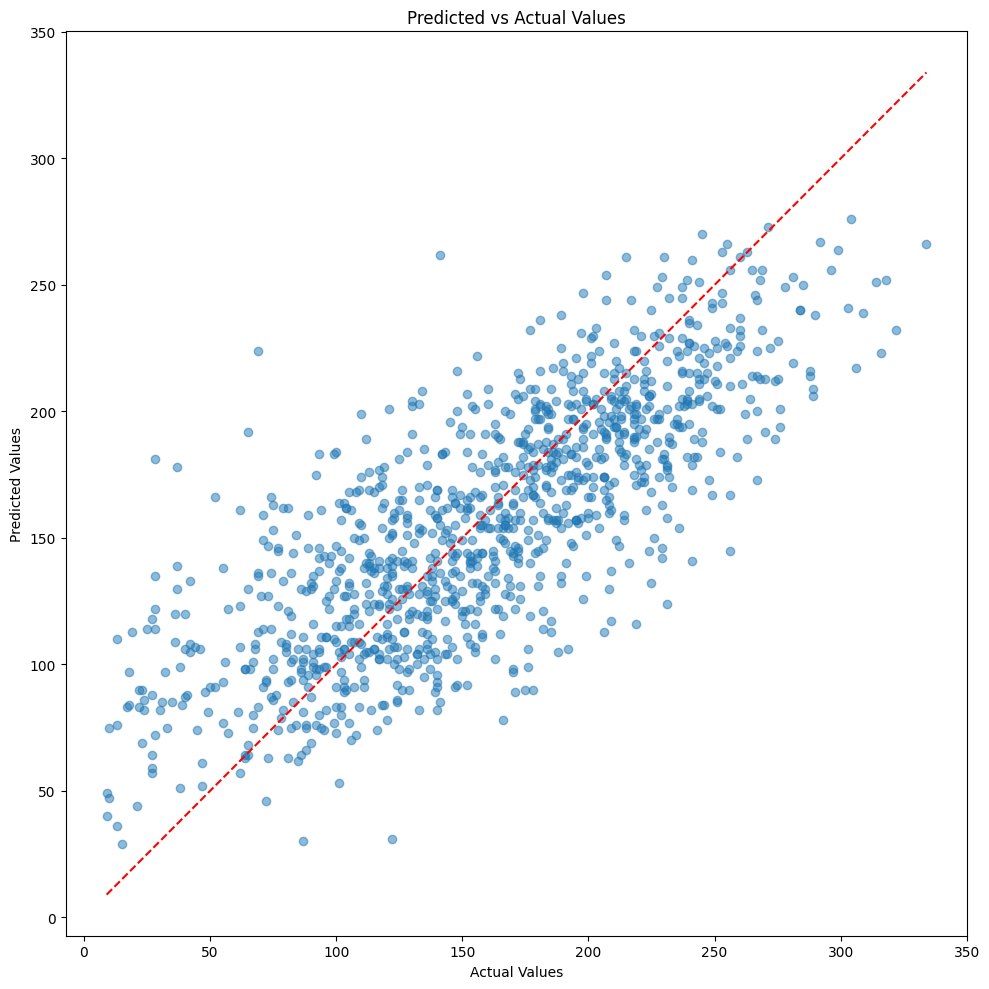

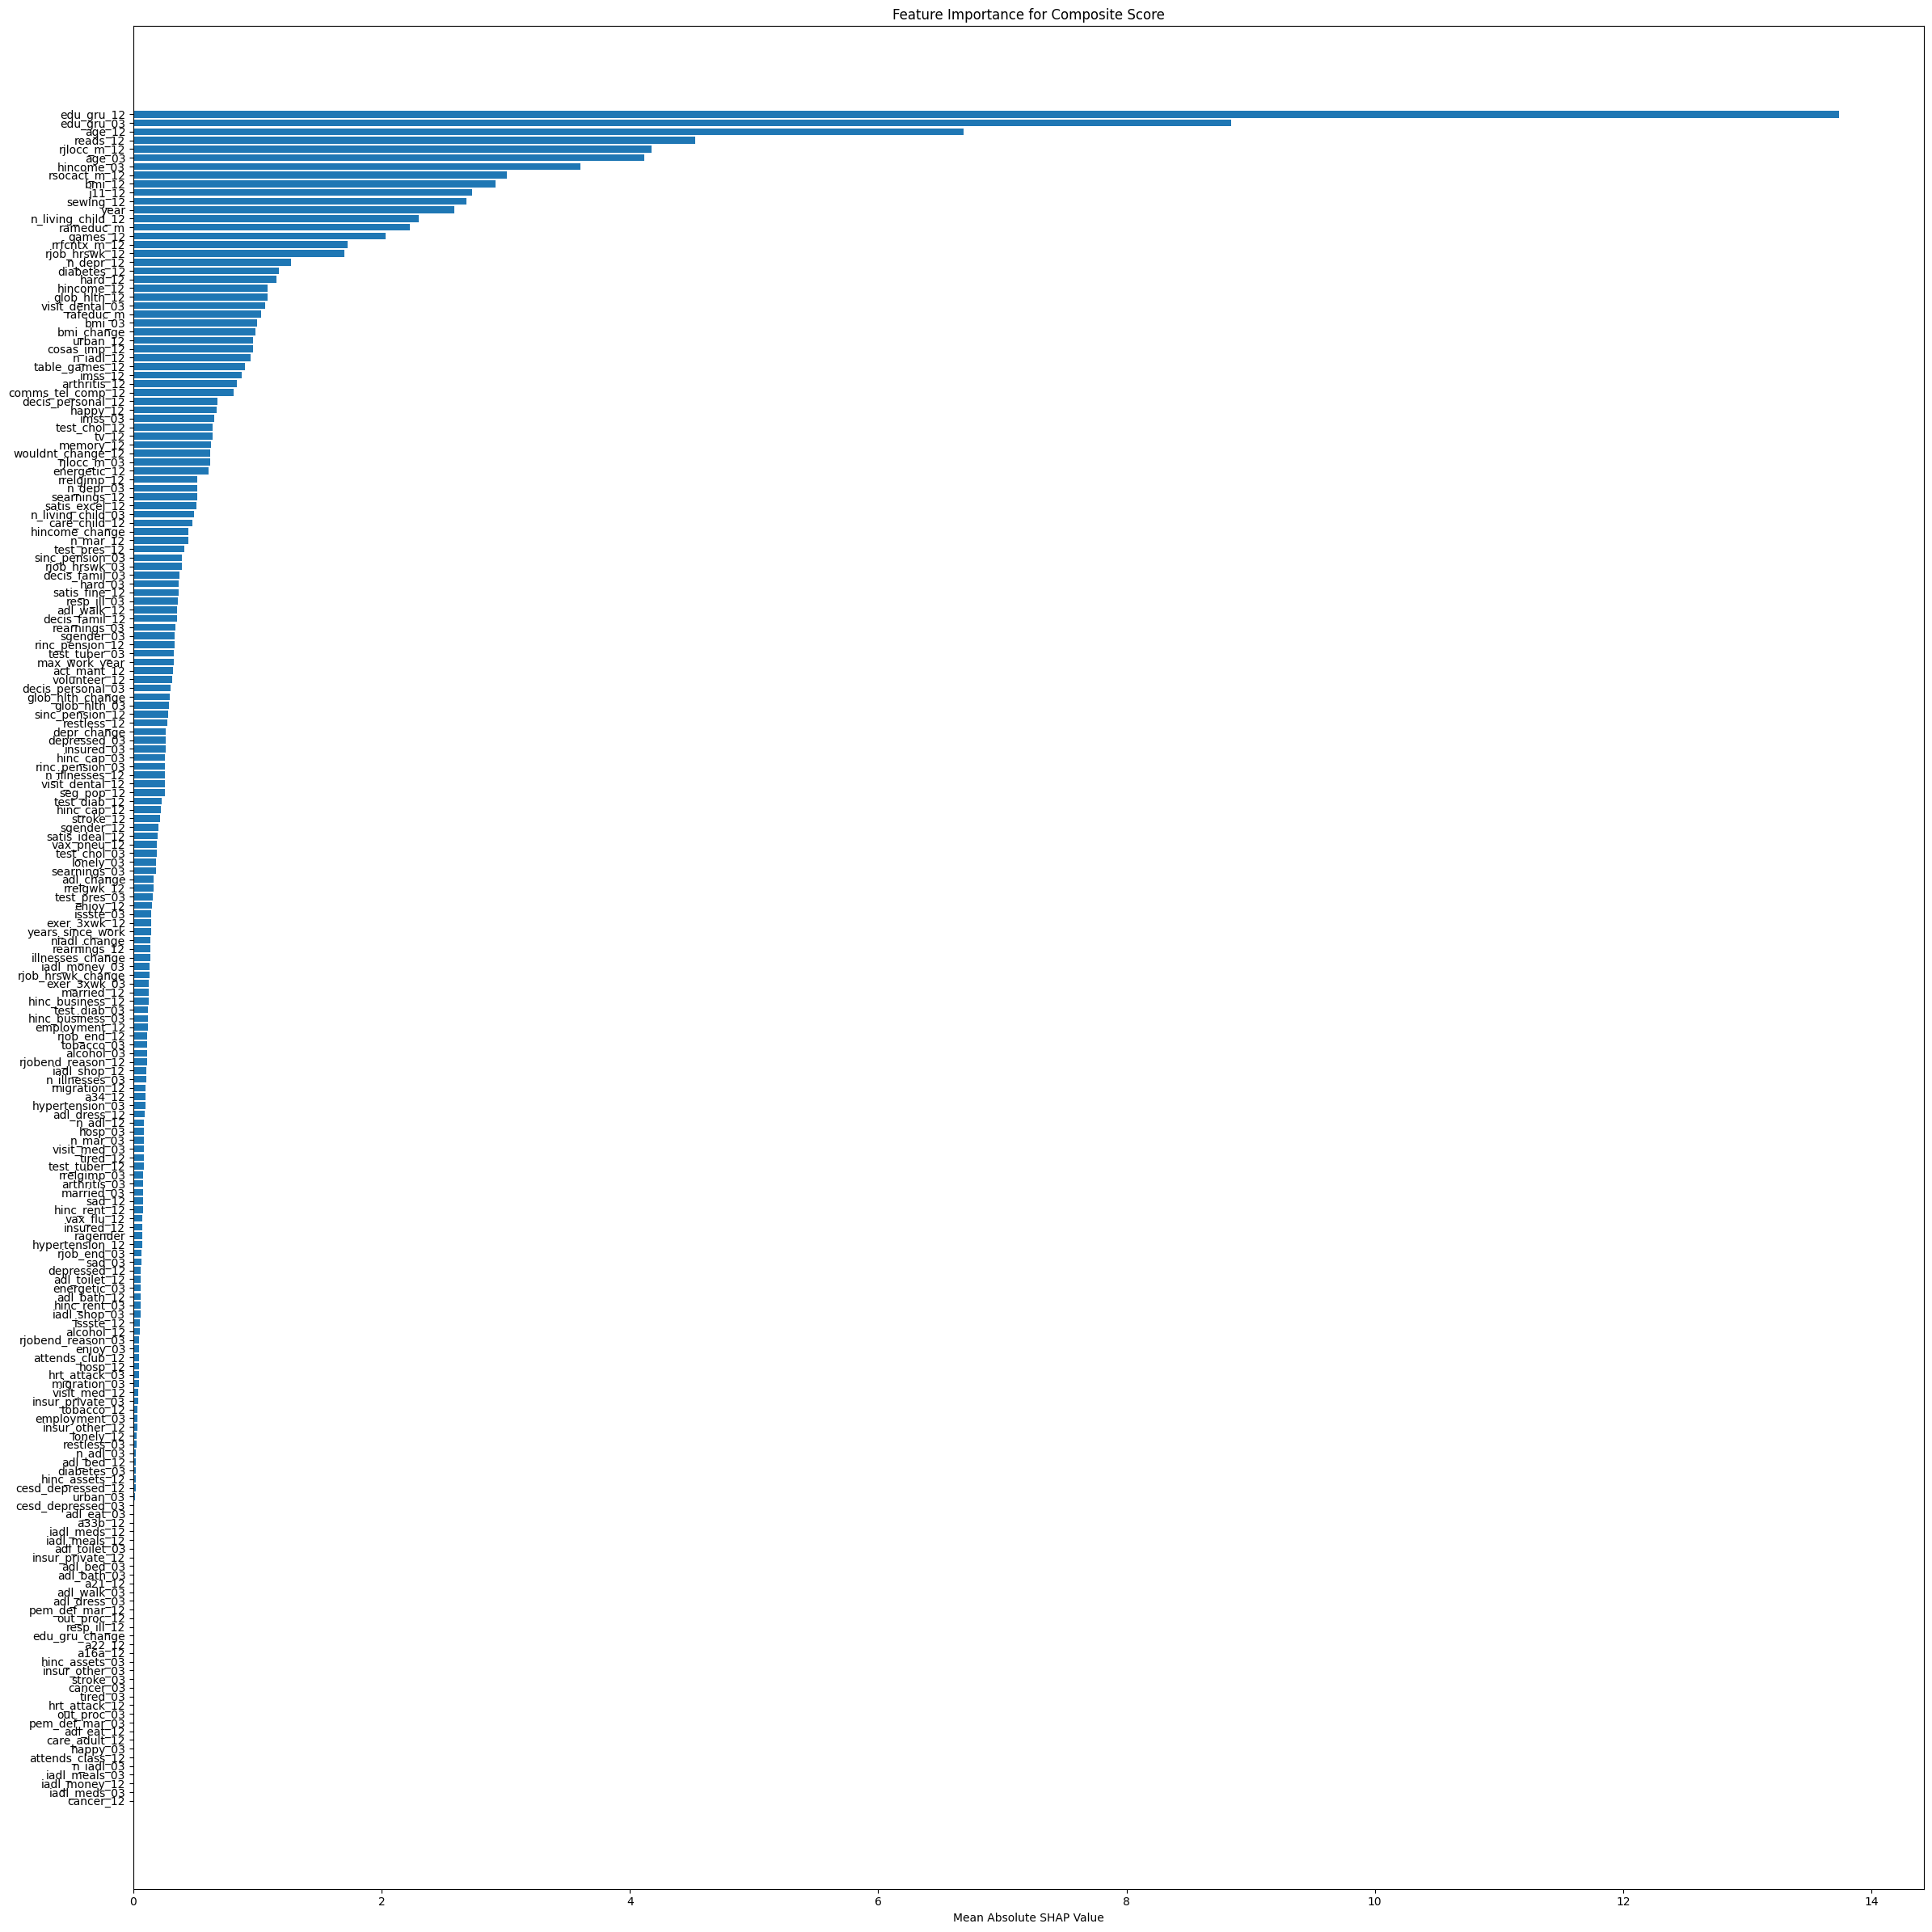

In [48]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(main_df, y, test_size=0.001, random_state=42)

# Best parameters for CatBoost
best_params = {
  'learning_rate': 0.07089438962267576,
  'num_leaves': 49,
  'max_depth': 4,
  'feature_fraction': 0.4839642718097913,
  'bagging_fraction': 0.5497799156909652,
  'lambda_l1': 0.058207015936292725,
  'lambda_l2': 0.08350139961819975,
  'min_child_samples': 85,
  'n_estimators': 4077,
  'objective': 'regression',
  'metric': 'rmse',
  'random_state': 42
}

model2 = lgb.train(
    params=best_params,
    train_set=lgb.Dataset(X_train, label=y_train, categorical_feature='auto'),
    valid_sets=lgb.Dataset(X_val, label=y_val, categorical_feature='auto'),
    num_boost_round=best_params['n_estimators'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=500, verbose=True),
    ]
)

# Make predictions
y_pred = model2.predict(test_df)
y_pred = np.round(y_pred).astype(int)

# Calculate metrics
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual
def plot_predictions_vs_actual(y_test, y_pred):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.tight_layout()
    # plt.savefig('/home/data3/Ali/Code/Moghis/results/LightBoost/predictions_vs_actual_composite_score.png', bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(y_test, y_pred)

explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(test_df)
feature_importance = pd.DataFrame({
    'Feature': main_df.columns.to_list(),
    'Mean_Absolute_SHAP': np.mean(np.abs(shap_values), axis=0)
})

feature_importance = feature_importance.sort_values(by='Mean_Absolute_SHAP', ascending=False)

# feature_importance.to_csv('/home/data3/Ali/Code/Moghis/results/LightBoost/feature_importance_composite_score.csv', index=False)
plt.figure(figsize=(24, 24))
plt.barh(feature_importance['Feature'], feature_importance['Mean_Absolute_SHAP'])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance for Composite Score')
plt.tight_layout()
plt.show()
# plt.savefig('/home/data3/Ali/Code/Moghis/results/LightBoost/feature_importance_plot_composite_score.png', bbox_inches='tight')
plt.close()

## CatBoost ##

0:	learn: 60.2328742	test: 70.2511139	best: 70.2511139 (0)	total: 9.33ms	remaining: 11.4s
100:	learn: 41.3925974	test: 46.7546765	best: 46.7546765 (100)	total: 884ms	remaining: 9.83s
200:	learn: 38.6240108	test: 40.1624675	best: 40.1624675 (200)	total: 1.8s	remaining: 9.14s
300:	learn: 37.1348037	test: 37.3507143	best: 37.3403904 (299)	total: 2.81s	remaining: 8.61s
400:	learn: 35.6643537	test: 36.6687054	best: 36.5536159 (398)	total: 3.77s	remaining: 7.74s
500:	learn: 34.1788256	test: 35.7284741	best: 35.2541153 (468)	total: 4.73s	remaining: 6.82s
600:	learn: 33.0934189	test: 35.5874344	best: 35.2541153 (468)	total: 5.87s	remaining: 6.08s
700:	learn: 32.0378928	test: 35.0526244	best: 34.9646090 (677)	total: 6.95s	remaining: 5.18s
800:	learn: 31.0457357	test: 35.5191549	best: 34.9508528 (706)	total: 8.05s	remaining: 4.25s
900:	learn: 30.1705533	test: 36.0567949	best: 34.9508528 (706)	total: 9.06s	remaining: 3.25s
1000:	learn: 29.3678066	test: 36.1936538	best: 34.9508528 (706)	total: 10.

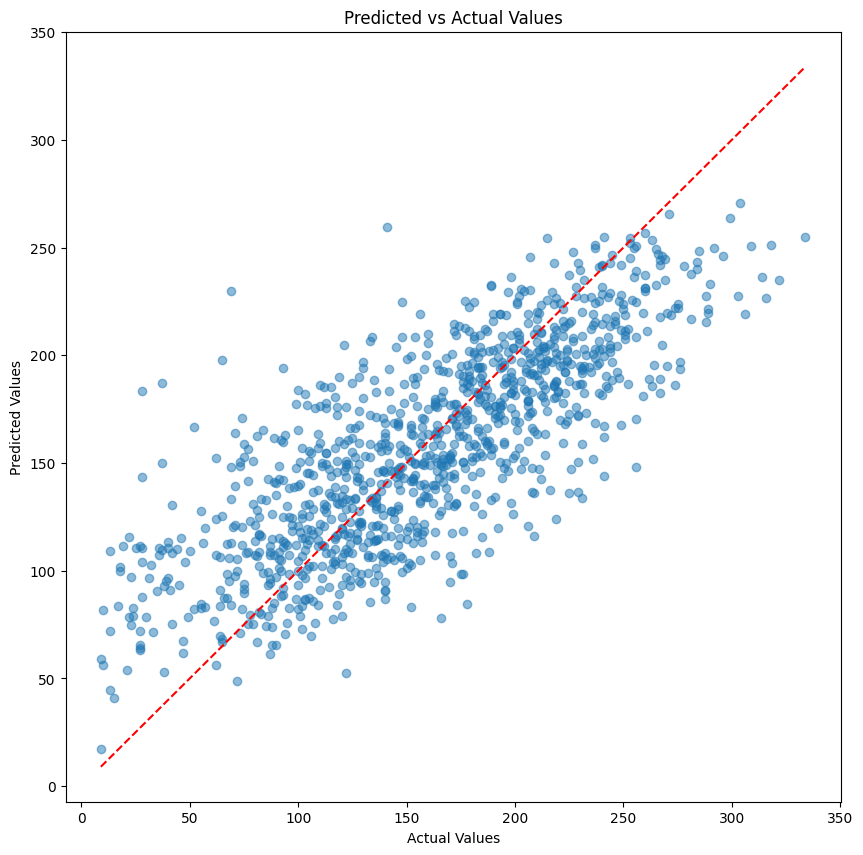

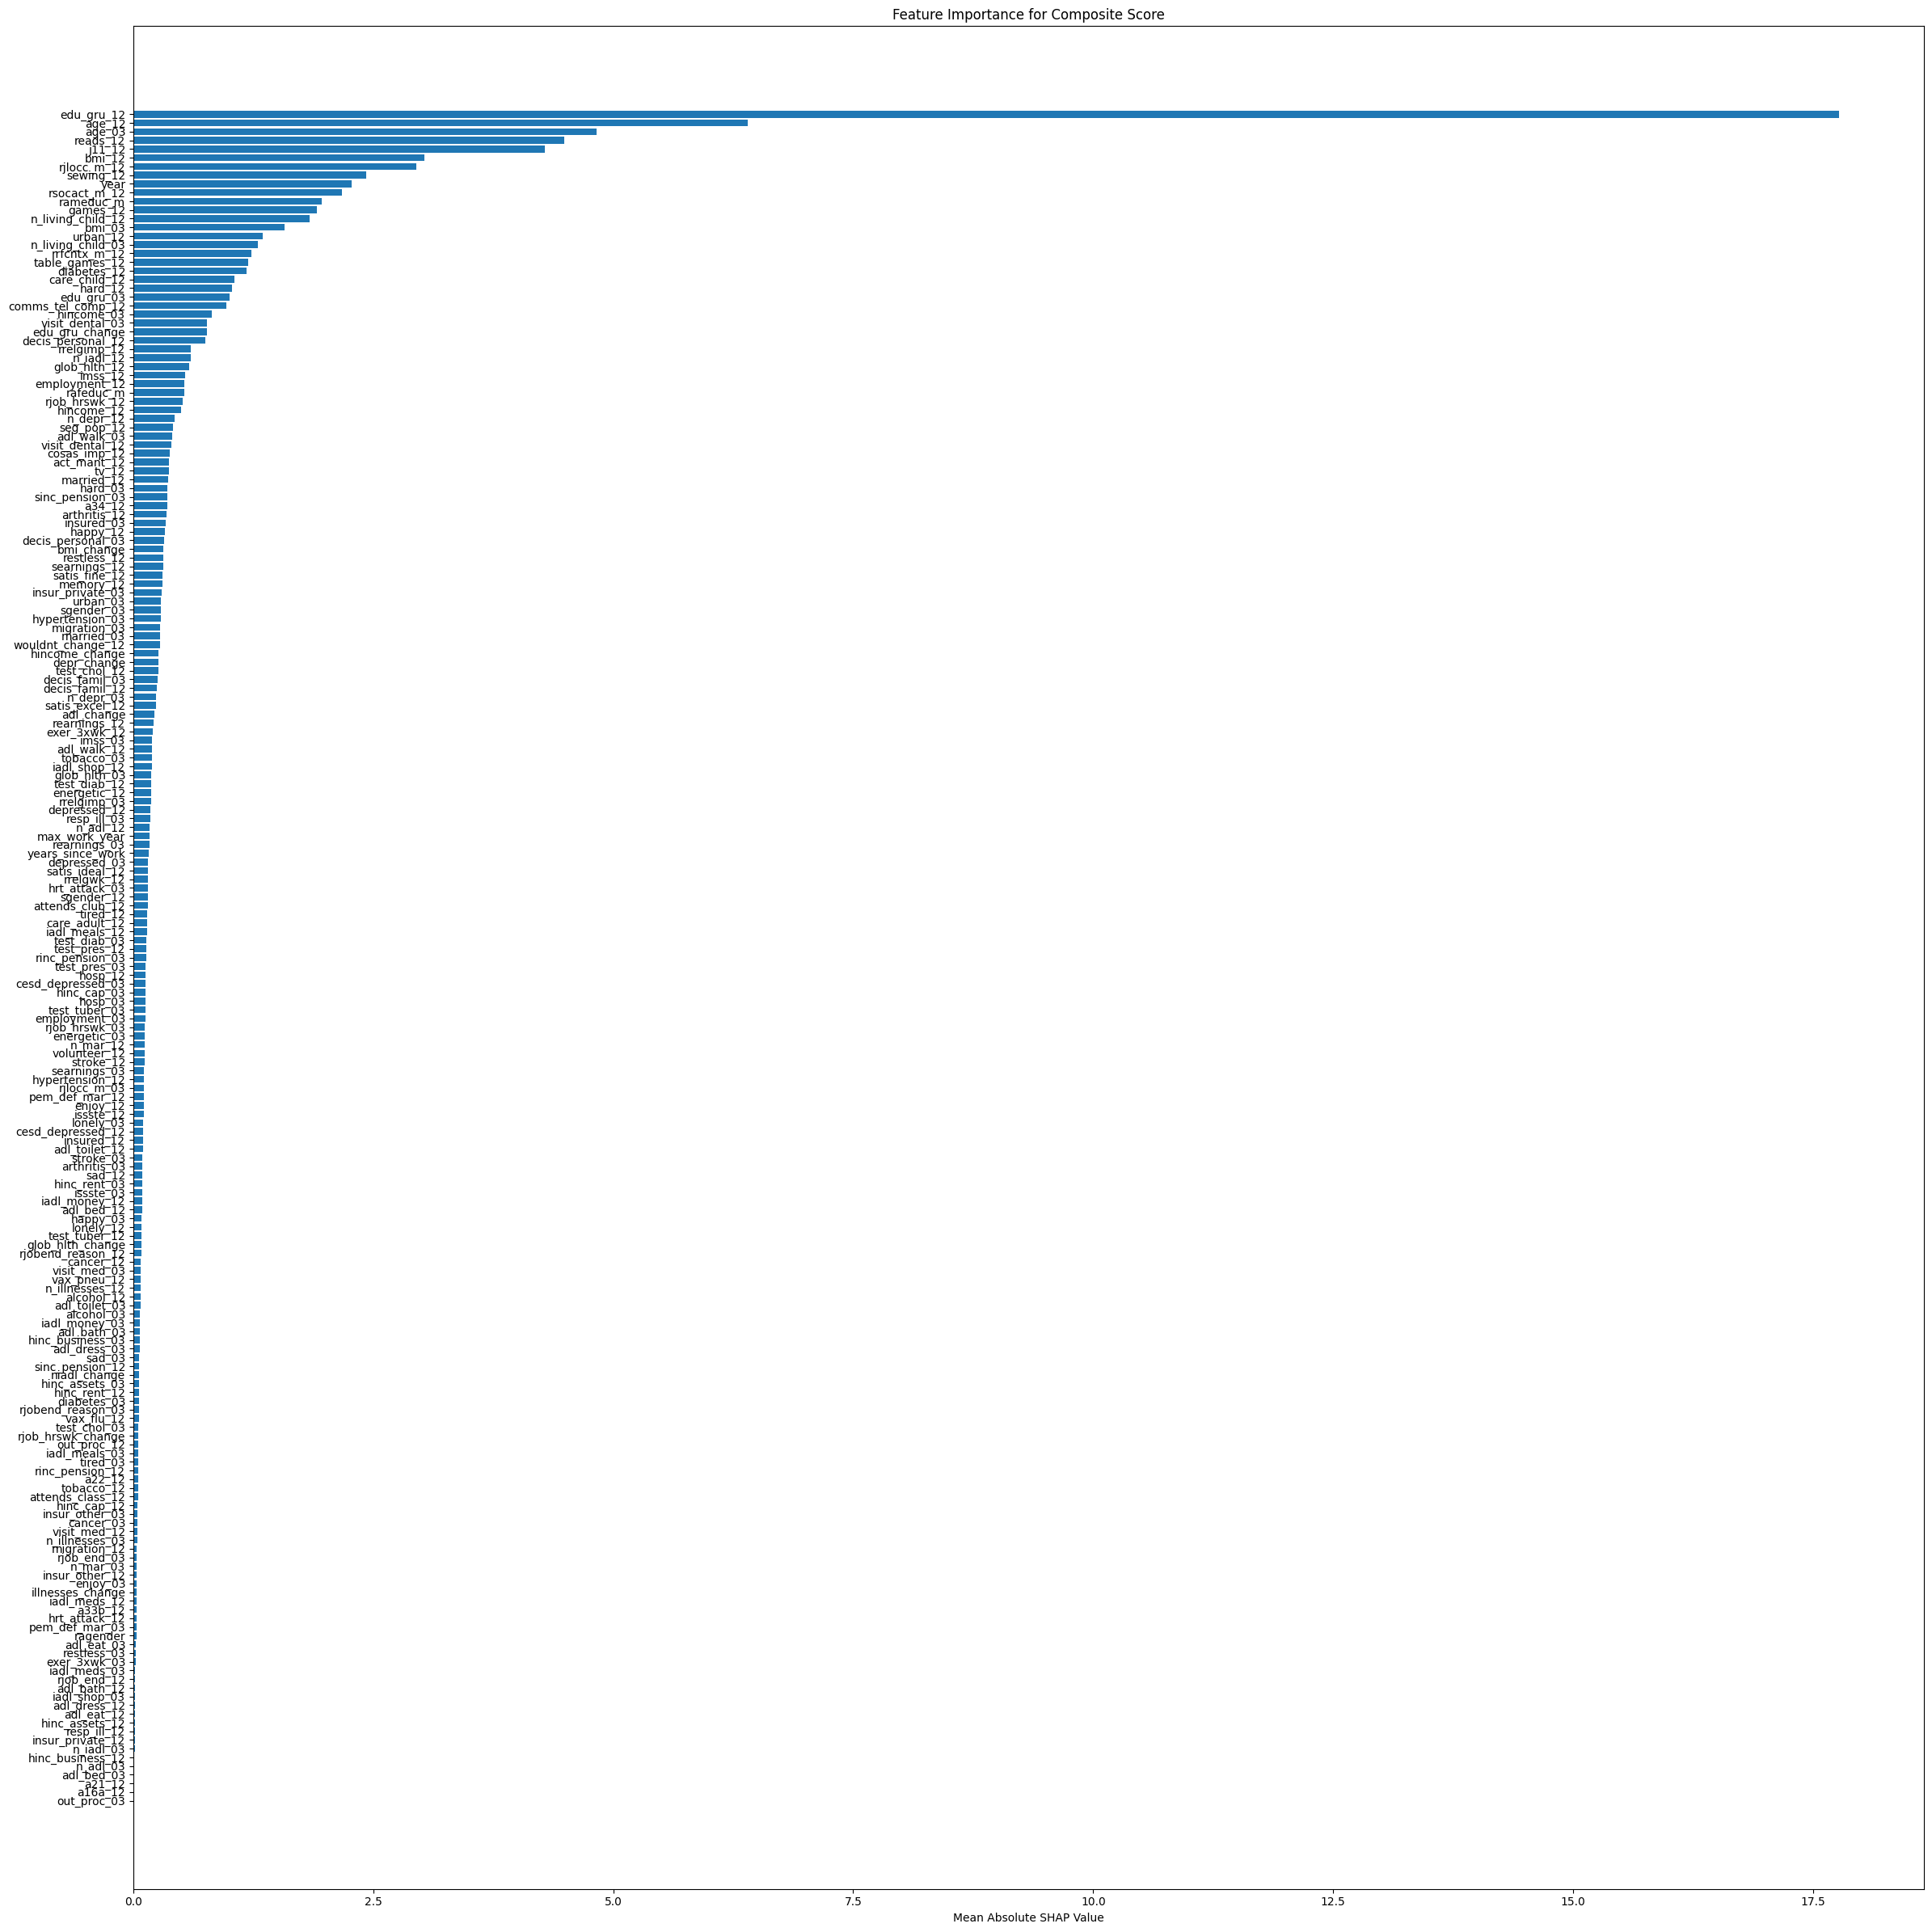

In [51]:
X_train, X_val, y_train, y_val = train_test_split(main_df, y, test_size=0.001, random_state=42)


# Best parameters for CatBoost
best_params = {
    'depth': 6,
    'learning_rate': 0.025804617832891515,
    'l2_leaf_reg': 0.22567510948252656,
    'random_strength': 1.8064759944089426,
    'bagging_temperature': 0.4675254776654324,
    'iterations': 1224
}

# Initialize and train CatBoostRegressor
# categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
model2 = CatBoostRegressor(
    **best_params,
    loss_function='RMSE',
    cat_features=main_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100,
    early_stopping_rounds=500,
    random_state=42
)
model2.fit(X_train, y_train, eval_set=(X_val, y_val))

# Make predictions
y_pred = model2.predict(test_df)

# Calculate metrics
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual
def plot_predictions_vs_actual(y_test, y_pred):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.show()

plot_predictions_vs_actual(y_test, y_pred)
# plt.savefig('/home/data3/Ali/Code/Moghis/results/predictions_vs_actual_composite_score.png', bbox_inches='tight')

explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(test_df)
feature_importance = pd.DataFrame({
    'Feature': main_df.columns.to_list(),
    'Mean_Absolute_SHAP': np.mean(np.abs(shap_values), axis=0)
})
feature_importance = feature_importance.sort_values(by='Mean_Absolute_SHAP', ascending=False)

# feature_importance.to_csv('/home/data3/Ali/Code/Moghis/results/feature_importance_composite_score.csv', index=False)
plt.figure(figsize=(24, 24))
plt.barh(feature_importance['Feature'], feature_importance['Mean_Absolute_SHAP'])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance for Composite Score')
plt.tight_layout()
plt.show()
# plt.savefig('/home/data3/Ali/Code/Moghis/results/feature_importance_plot_composite_score.png', bbox_inches='tight')
plt.close()



## XGBoost ##

[0]	validation_0-rmse:70.07182	validation_0-root_mean_squared_error:70.07182
[1]	validation_0-rmse:69.23374	validation_0-root_mean_squared_error:69.23374
[2]	validation_0-rmse:68.45840	validation_0-root_mean_squared_error:68.45840
[3]	validation_0-rmse:67.58054	validation_0-root_mean_squared_error:67.58054
[4]	validation_0-rmse:66.75906	validation_0-root_mean_squared_error:66.75906
[5]	validation_0-rmse:66.06690	validation_0-root_mean_squared_error:66.06690
[6]	validation_0-rmse:65.32407	validation_0-root_mean_squared_error:65.32407
[7]	validation_0-rmse:64.73959	validation_0-root_mean_squared_error:64.73959
[8]	validation_0-rmse:64.16536	validation_0-root_mean_squared_error:64.16536
[9]	validation_0-rmse:63.64817	validation_0-root_mean_squared_error:63.64817
[10]	validation_0-rmse:62.84326	validation_0-root_mean_squared_error:62.84326
[11]	validation_0-rmse:62.38333	validation_0-root_mean_squared_error:62.38332
[12]	validation_0-rmse:61.80279	validation_0-root_mean_squared_error:61.80

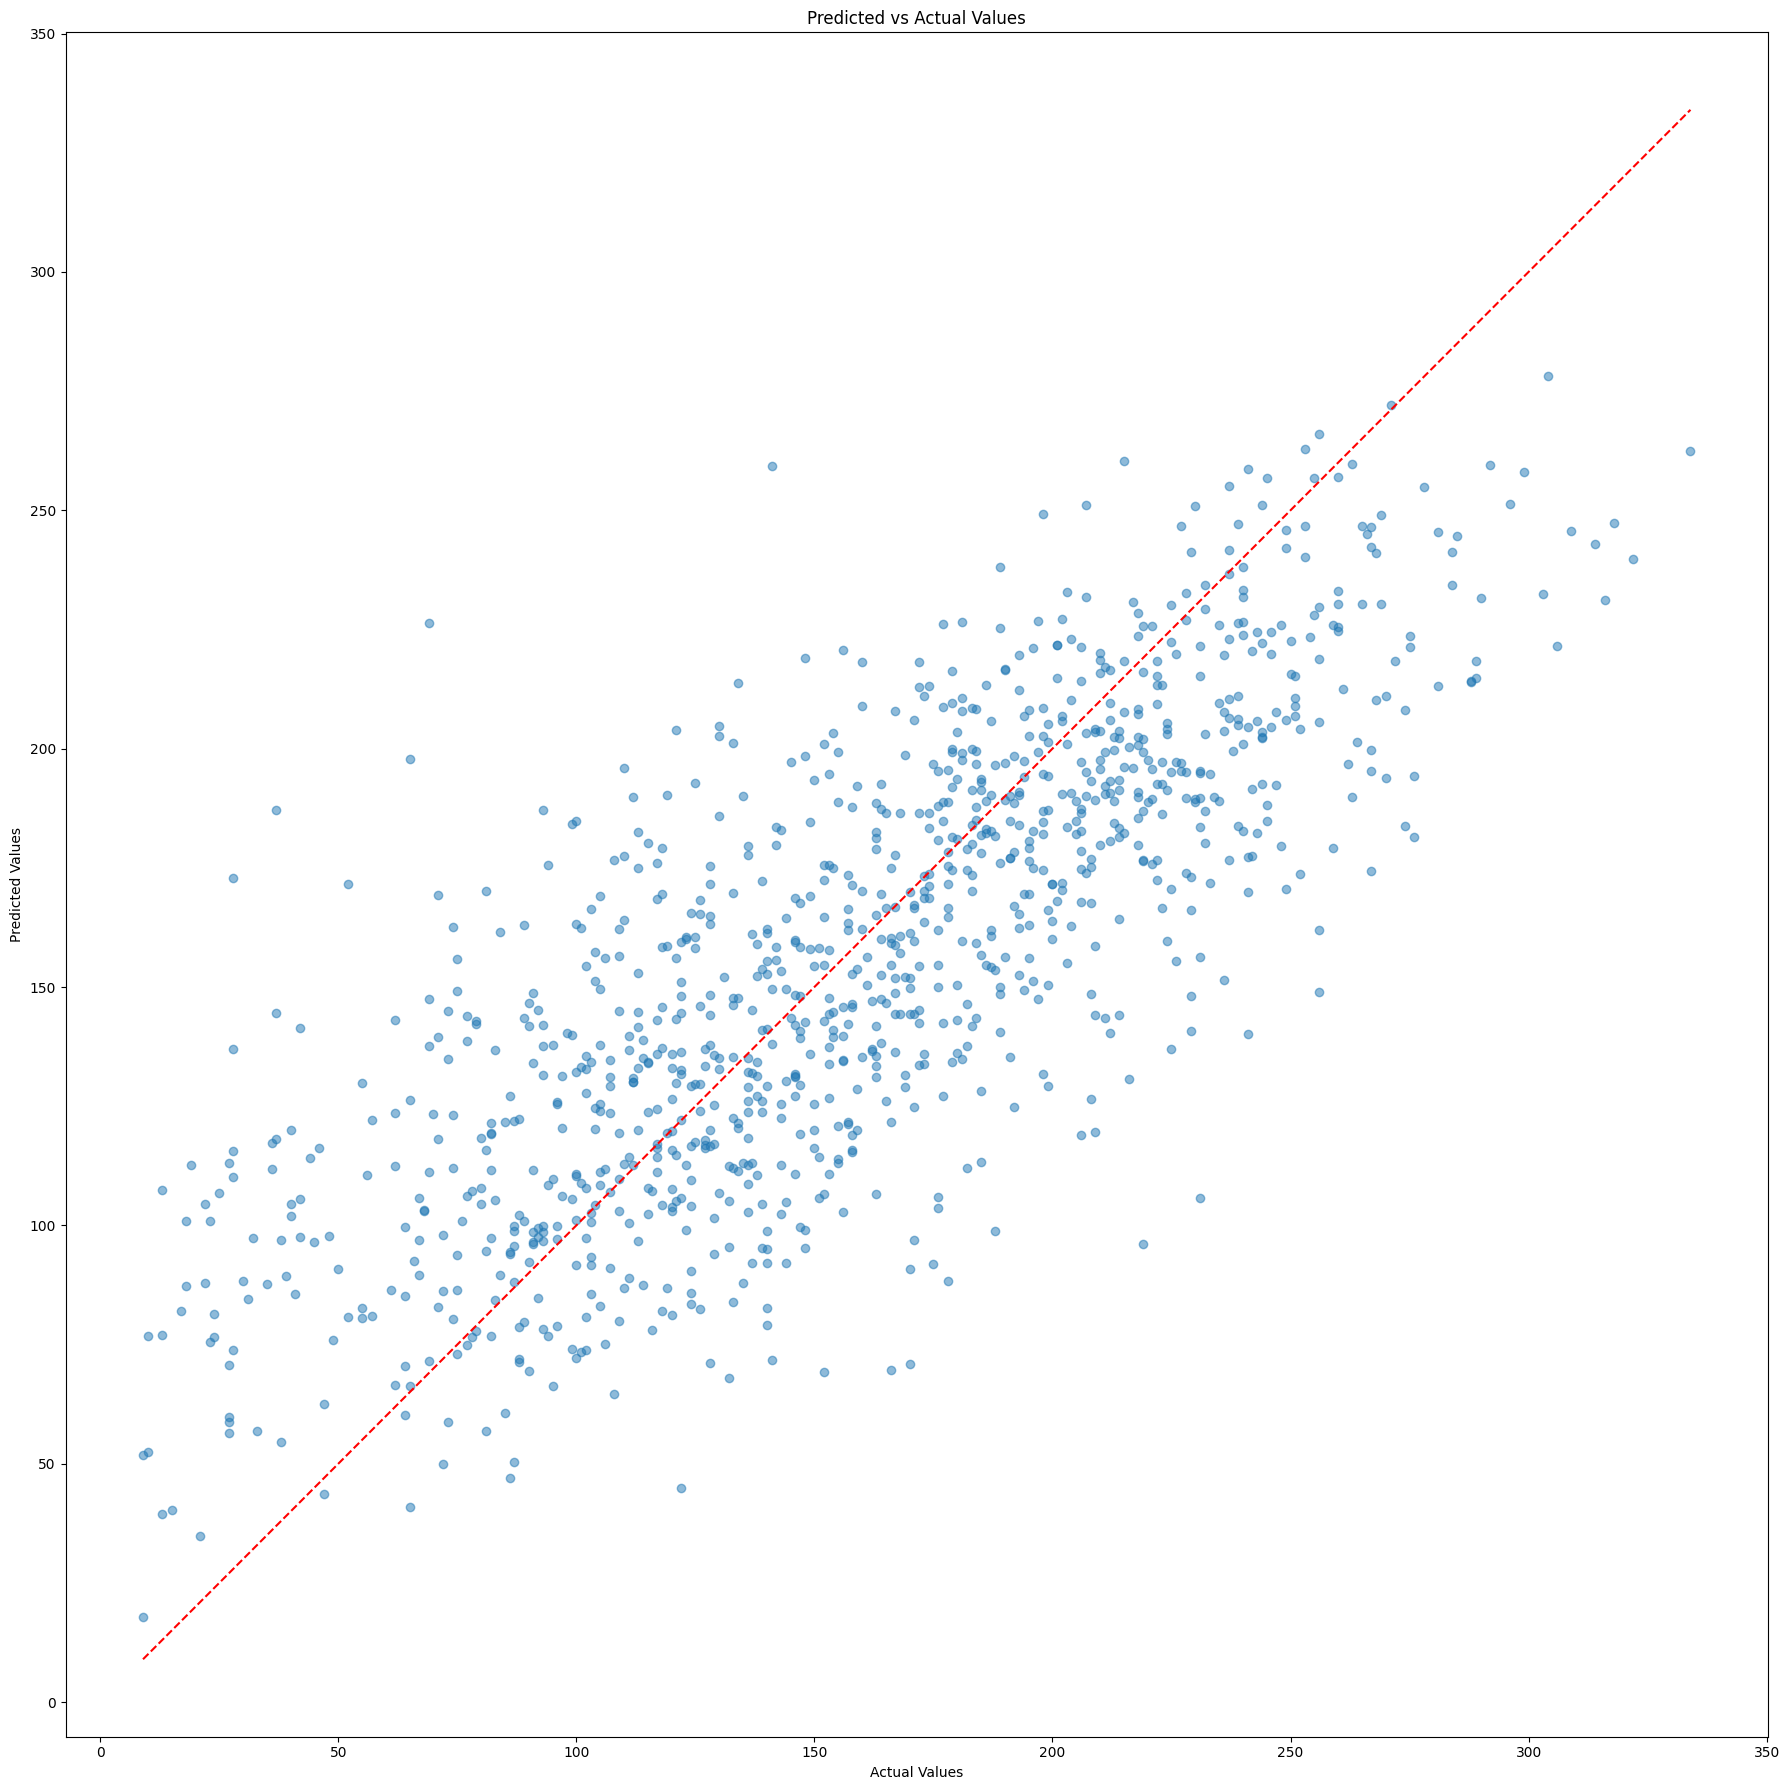

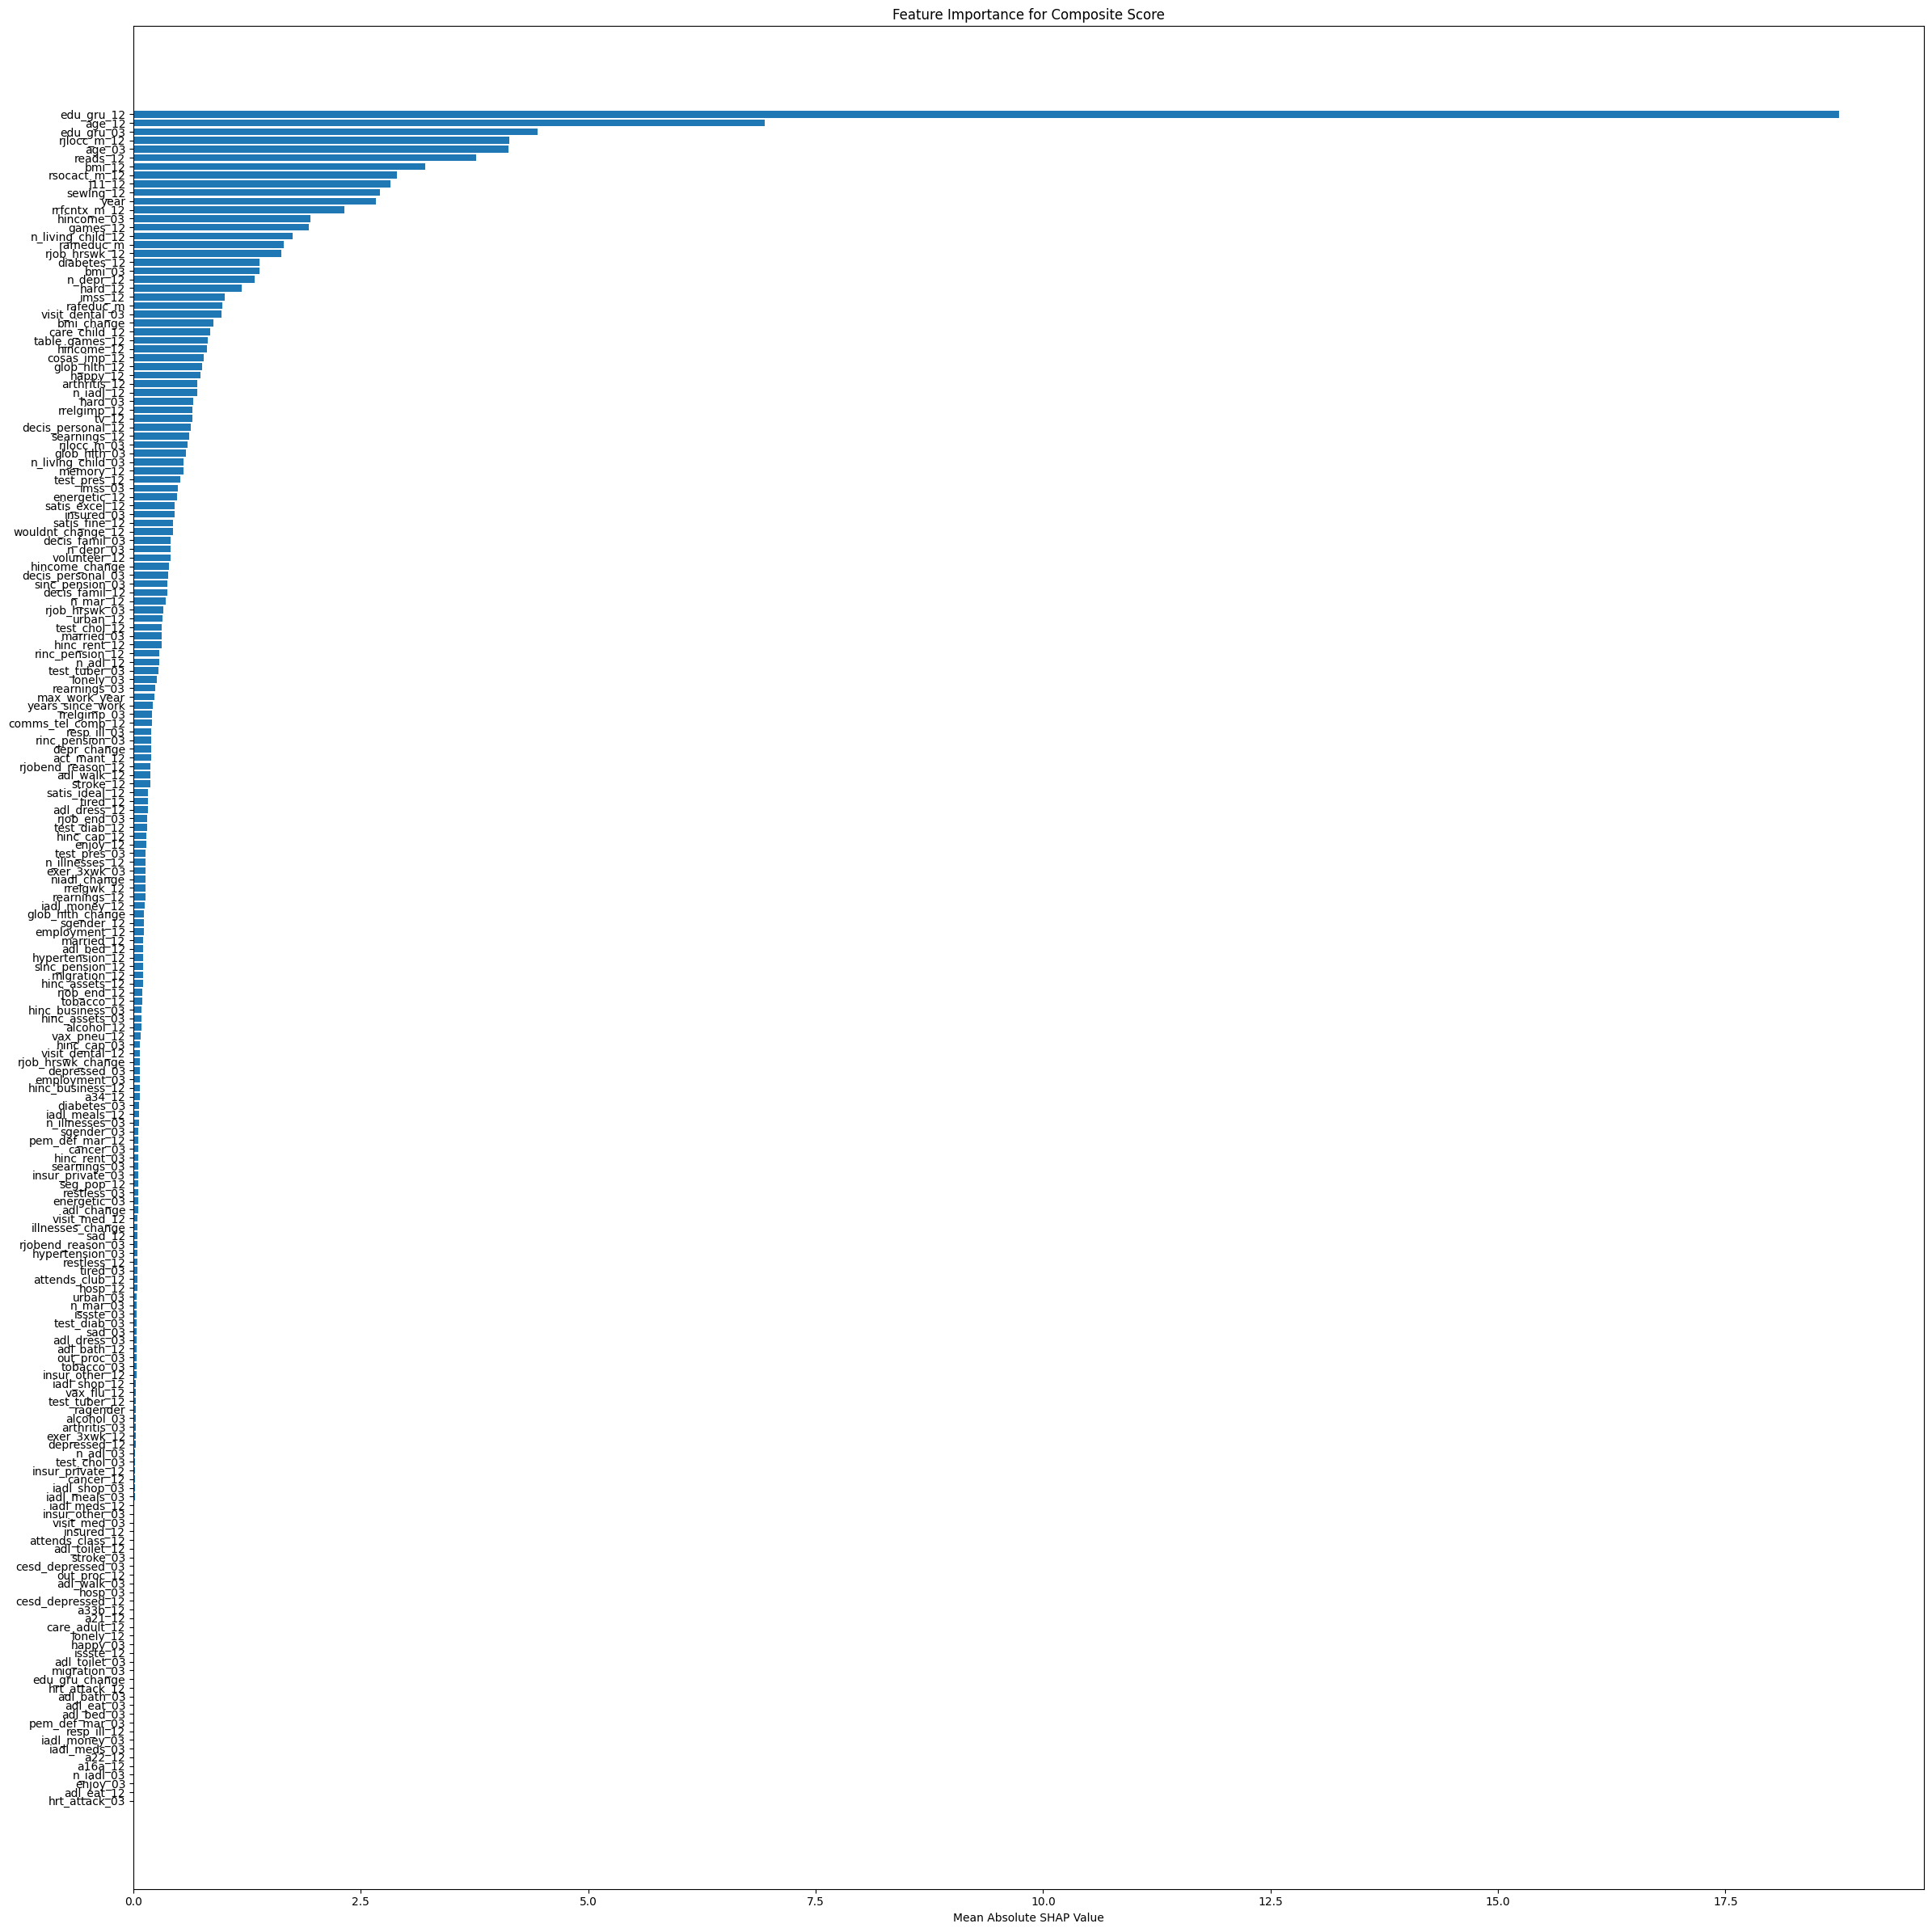

In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(main_df, y, test_size=0.001, random_state=42)

# Best parameters for XGBoost
best_params = {
  'learning_rate': 0.033763045458285304,
  'max_depth': 3,
  'min_child_weight': 14,
  'subsample': 0.9500263286639197,
  'colsample_bytree': 0.7747635615654157,
  'gamma': 7.558507636378349,
  'reg_alpha': 0.4378783168336932,
  'reg_lambda': 2.8408676886824322,
  'n_estimators': 2804
  }


model2 = XGBRegressor(**best_params, random_state=42, enable_categorical=True, early_stopping_rounds=500, eval_metric=root_mean_squared_error,)
model2.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Make predictions
y_pred = model2.predict(test_df)

# Calculate metrics
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual
def plot_predictions_vs_actual(y_test, y_pred):
    plt.figure(figsize=(18, 18))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.tight_layout()
    # plt.savefig('/home/data3/Ali/Code/Moghis/results/XGBoost/predictions_vs_actual_composite_score.png', bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(y_test, y_pred)

explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(test_df)
feature_importance = pd.DataFrame({
    'Feature': main_df.columns.to_list(),
    'Mean_Absolute_SHAP': np.mean(np.abs(shap_values), axis=0)
})

feature_importance = feature_importance.sort_values(by='Mean_Absolute_SHAP', ascending=False)

# feature_importance.to_csv('/home/data3/Ali/Code/Moghis/results/XGBoost/feature_importance_composite_score.csv', index=False)
plt.figure(figsize=(24, 24))
plt.barh(feature_importance['Feature'], feature_importance['Mean_Absolute_SHAP'])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance for Composite Score')
plt.tight_layout()
plt.show()
# plt.savefig('/home/data3/Ali/Code/Moghis/results/XGBoost/feature_importance_plot_composite_score.png', bbox_inches='tight')
plt.close()

## Random Forest ##

In [63]:
main_df = main_df.apply(pd.to_numeric, errors='coerce')

In [64]:
main_df

,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,adl_walk_03,...,max_work_year,years_since_work,hincome_change,niadl_change,adl_change,depr_change,glob_hlth_change,bmi_change,edu_gru_change,illnesses_change
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.0,3.0,NaN,0.0,1.0,0.0,0.0,...,2003.0,18.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,NaN,NaN,NaN,1.0,1.0,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,20000.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.0
4339,NaN,NaN,NaN,1.0,1.0,NaN,0.0,1.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,1.0,1.0,NaN,0.0,-2.0
4340,NaN,NaN,NaN,1.0,1.0,NaN,0.0,1.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,1.0,1.0,NaN,0.0,-2.0
4341,NaN,NaN,NaN,1.0,0.0,NaN,0.0,2.0,0.0,0.0,...,NaN,NaN,-10000.0,NaN,0.0,NaN,NaN,NaN,0.0,-1.0



Mean Squared Error: 41.9598
R^2 Score: 0.5602


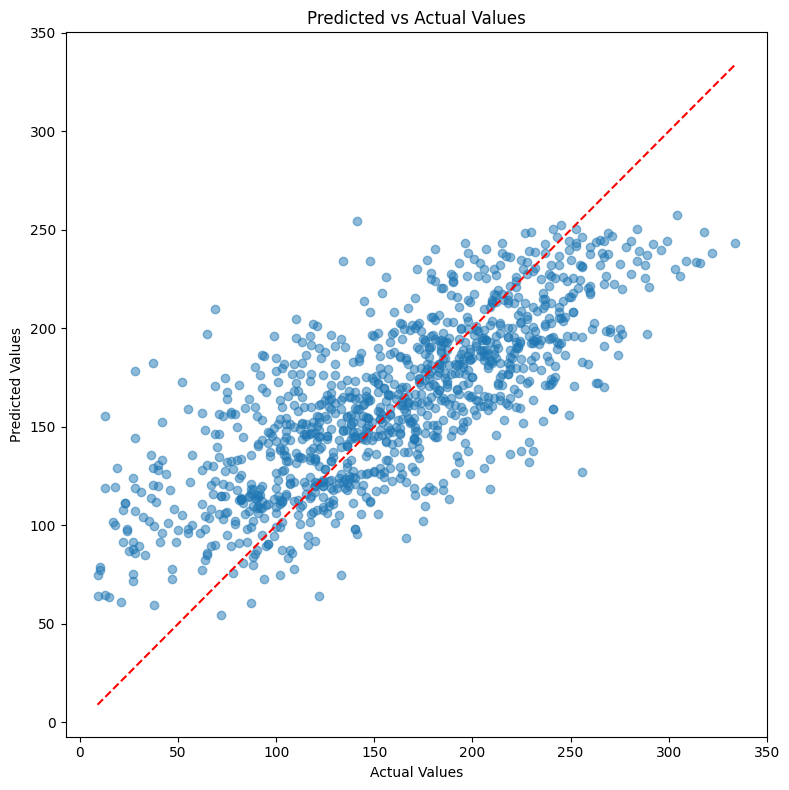

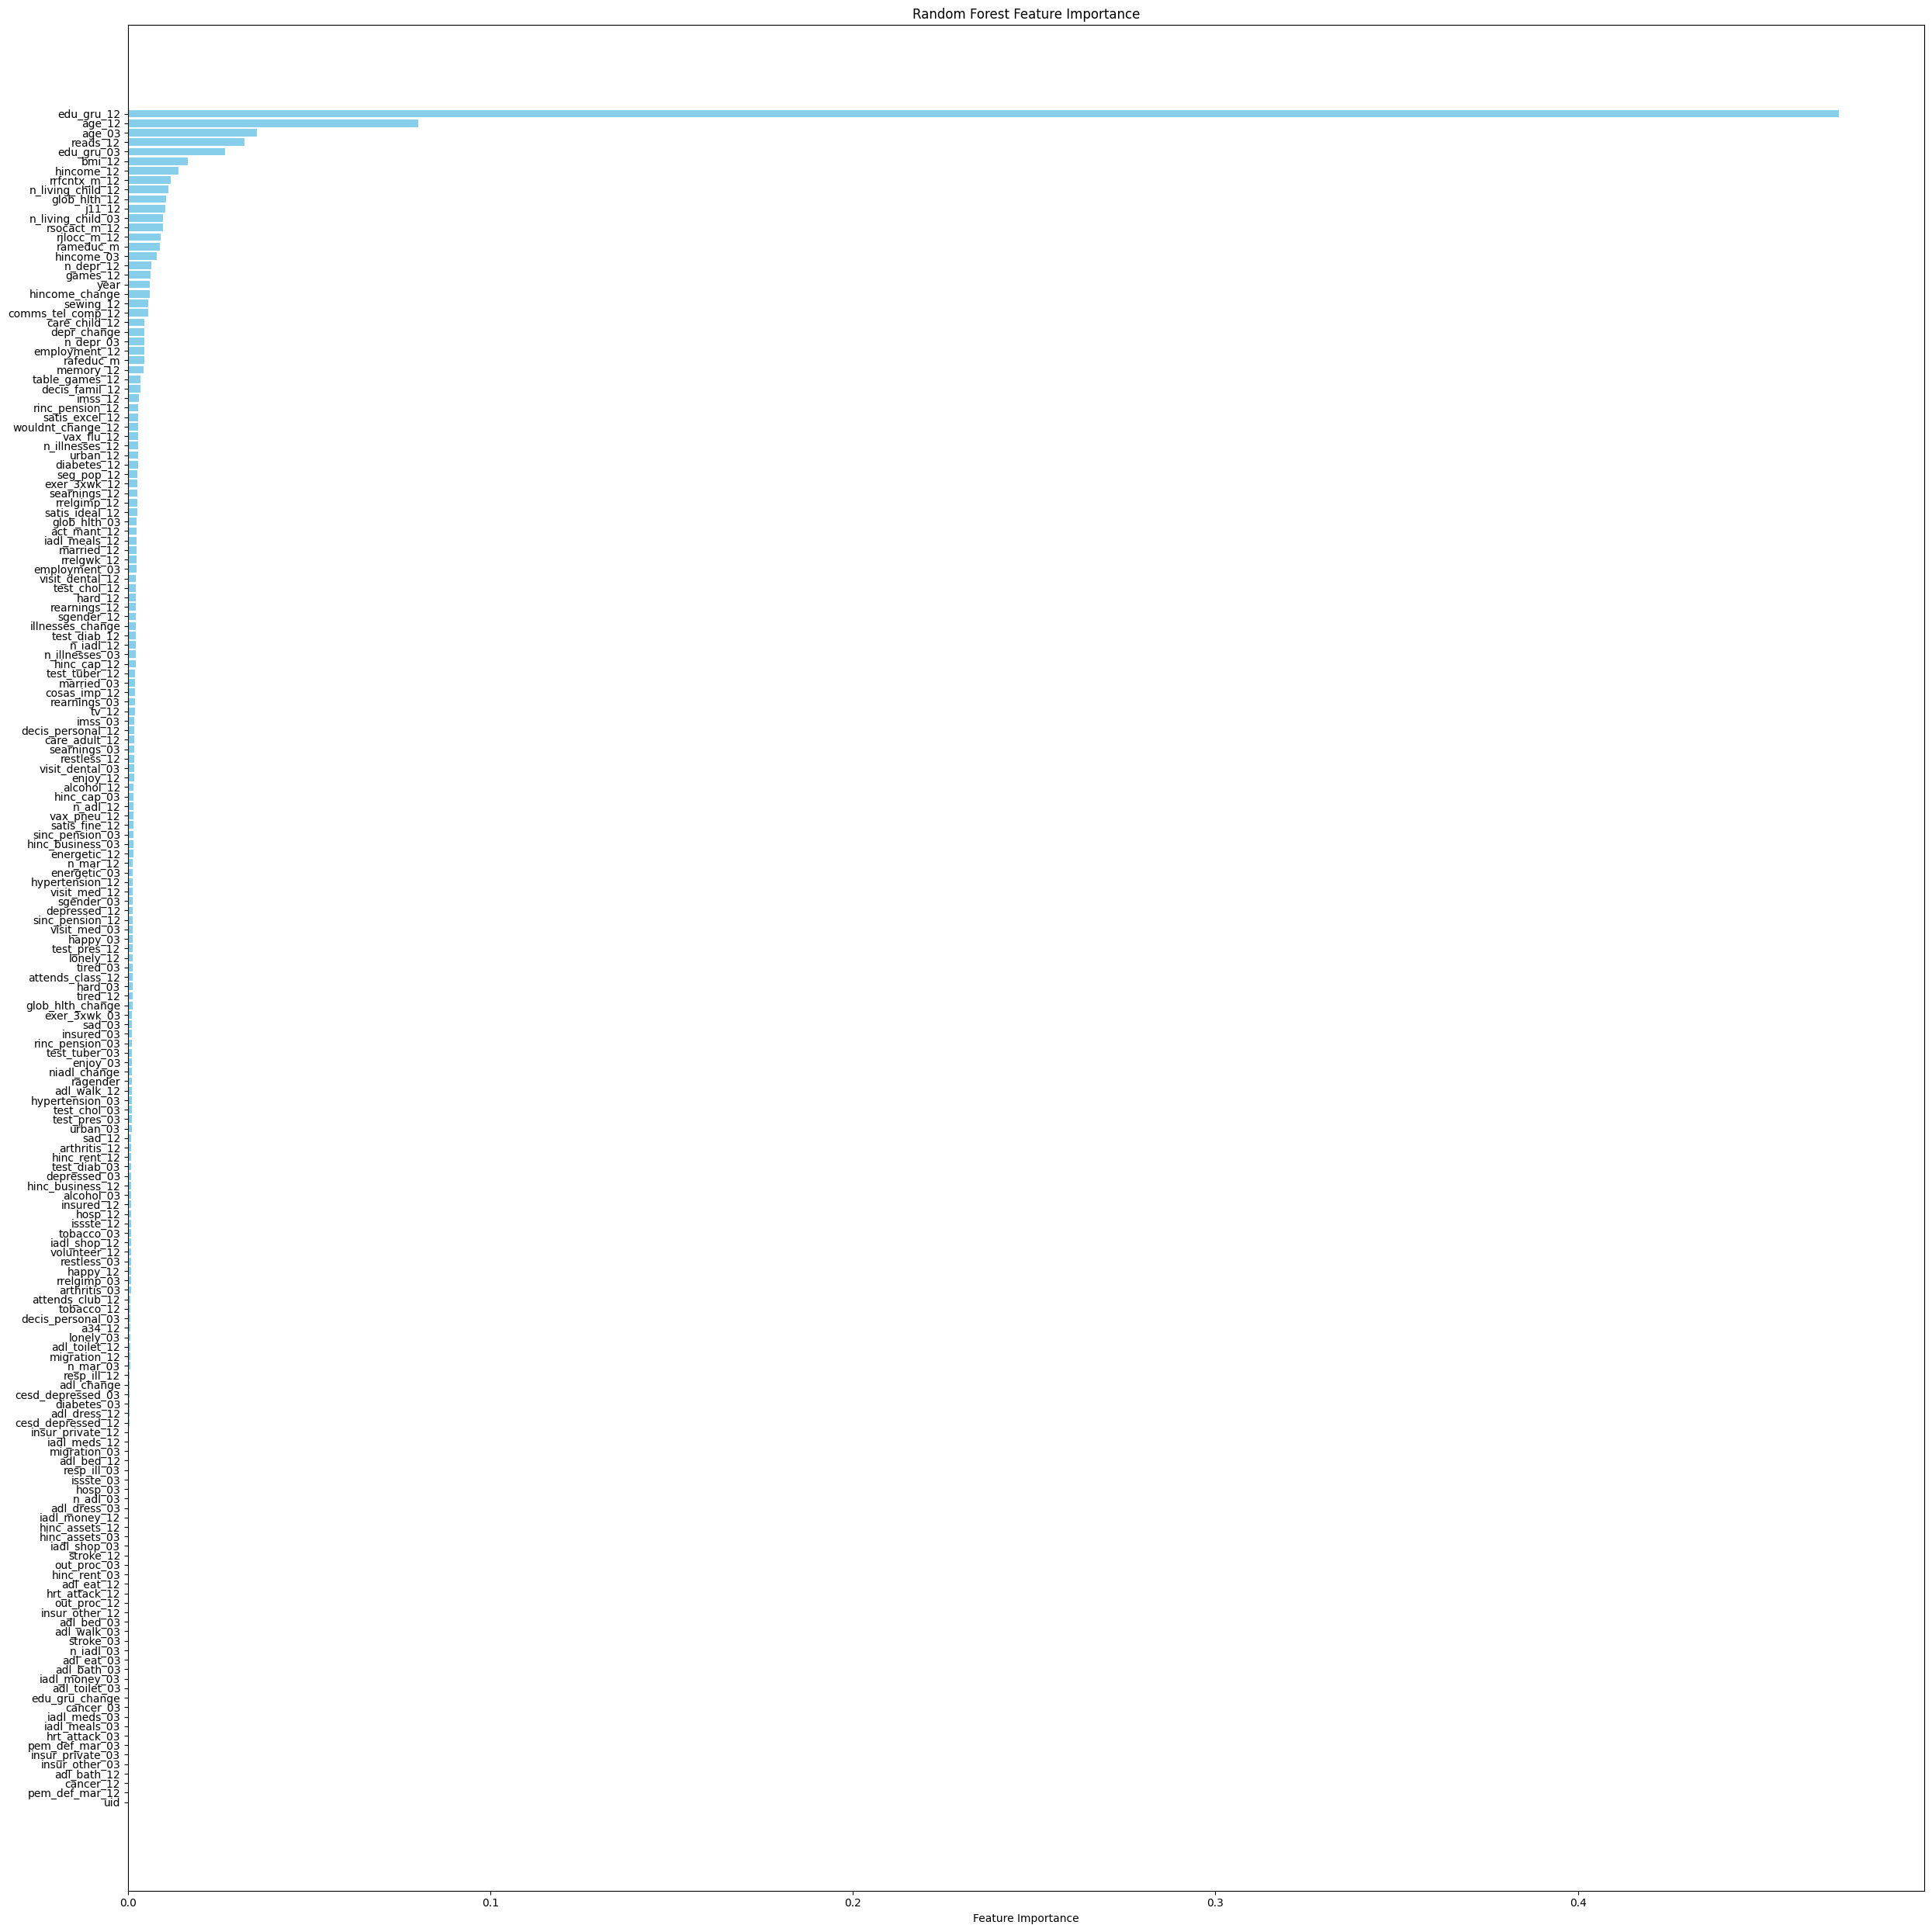

In [70]:
# Load and preprocess data Train
file_path = '/u/spa-d4/grad/mfe261/Projects/PREPARE/Ali/Train-data-preprocessed-2.xlsx'
data = pd.read_excel(file_path)

# Load and preprocess data Test
file_path = '/u/spa-d4/grad/mfe261/Projects/PREPARE/Ali/Test-data-preprocessed-2.xlsx'
data_test = pd.read_excel(file_path)


# Define features and target
features = [
    'uid', 'age_03', 'urban_03', 'married_03', 'n_mar_03', 'edu_gru_03', 'n_living_child_03',
    'migration_03', 'glob_hlth_03', 'adl_dress_03', 'adl_walk_03', 'adl_bath_03', 'adl_eat_03',
    'adl_bed_03', 'adl_toilet_03', 'n_adl_03', 'iadl_money_03', 'iadl_meds_03', 'iadl_shop_03',
    'iadl_meals_03', 'n_iadl_03', 'depressed_03', 'hard_03', 'restless_03', 'happy_03', 'lonely_03',
    'enjoy_03', 'sad_03', 'tired_03', 'energetic_03', 'n_depr_03', 'cesd_depressed_03',
    'hypertension_03', 'diabetes_03', 'resp_ill_03', 'arthritis_03', 'hrt_attack_03', 'stroke_03',
    'cancer_03', 'n_illnesses_03', 'exer_3xwk_03', 'alcohol_03', 'tobacco_03', 'test_chol_03',
    'test_tuber_03', 'test_diab_03', 'test_pres_03', 'hosp_03', 'visit_med_03', 'out_proc_03',
    'visit_dental_03', 'imss_03', 'issste_03', 'pem_def_mar_03', 'insur_private_03', 'insur_other_03',
    'insured_03', 'decis_personal_03', 'employment_03', 'age_12', 'urban_12', 'married_12',
    'n_mar_12', 'edu_gru_12', 'n_living_child_12', 'migration_12', 'glob_hlth_12', 'adl_dress_12',
    'adl_walk_12', 'adl_bath_12', 'adl_eat_12', 'adl_bed_12', 'adl_toilet_12', 'n_adl_12',
    'iadl_money_12', 'iadl_meds_12', 'iadl_shop_12', 'iadl_meals_12', 'n_iadl_12', 'depressed_12',
    'hard_12', 'restless_12', 'happy_12', 'lonely_12', 'enjoy_12', 'sad_12', 'tired_12',
    'energetic_12', 'n_depr_12', 'cesd_depressed_12', 'hypertension_12', 'diabetes_12',
    'resp_ill_12', 'arthritis_12', 'hrt_attack_12', 'stroke_12', 'cancer_12', 'n_illnesses_12',
    'bmi_12', 'exer_3xwk_12', 'alcohol_12', 'tobacco_12', 'test_chol_12', 'test_tuber_12',
    'test_diab_12', 'test_pres_12', 'hosp_12', 'visit_med_12', 'out_proc_12', 'visit_dental_12',
    'imss_12', 'issste_12', 'pem_def_mar_12', 'insur_private_12', 'insur_other_12', 'insured_12',
    'decis_famil_12', 'decis_personal_12', 'employment_12', 'vax_flu_12', 'vax_pneu_12', 'seg_pop_12',
    'care_adult_12', 'care_child_12', 'volunteer_12', 'attends_class_12', 'attends_club_12',
    'reads_12', 'games_12', 'table_games_12', 'comms_tel_comp_12', 'act_mant_12', 'tv_12',
    'sewing_12', 'satis_ideal_12', 'satis_excel_12', 'satis_fine_12', 'cosas_imp_12',
    'wouldnt_change_12', 'memory_12', 'ragender', 'rameduc_m', 'rafeduc_m', 'sgender_03',
    'rearnings_03', 'searnings_03', 'hincome_03', 'hinc_business_03', 'hinc_rent_03', 'hinc_assets_03',
    'hinc_cap_03', 'rinc_pension_03', 'sinc_pension_03', 'rrelgimp_03', 'sgender_12', 'rjlocc_m_12',
    'rearnings_12', 'searnings_12', 'hincome_12', 'hinc_business_12', 'hinc_rent_12', 'hinc_assets_12',
    'hinc_cap_12', 'rinc_pension_12', 'sinc_pension_12', 'rrelgimp_12', 'rrfcntx_m_12',
    'rsocact_m_12', 'rrelgwk_12', 'a34_12', 'j11_12', 'year', 'hincome_change',
    'niadl_change', 'adl_change', 'depr_change', 'glob_hlth_change', 'edu_gru_change',
    'illnesses_change'
    ]

target = 'composite_score'

######################## Process Train Data ####################
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data[features] = data[features].fillna(data[features].mean())
data = data.dropna(subset=[target])

X_train = data[features]
y_train = data[target]

######################## Process Test Data ####################
data_test[features] = data_test[features].apply(pd.to_numeric, errors='coerce')
data_test[features] = data_test[features].fillna(data[features].mean())
data_test = data_test.dropna(subset=[target])

X_test = data_test[features]
y_test = data_test[target]


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.001, random_state=42)

# Best parameters for CatBoost
best_params = {
  'max_depth': 30,
  'min_samples_split': 22,
  'min_samples_leaf': 6,
  'max_features': 0.8191960808589205,
  'n_estimators': 97
}

model2 = RandomForestRegressor(**best_params, random_state=42)
model2.fit(X_train, y_train)

# Make predictions
y_pred = model2.predict(X_test)

# Calculate metrics
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual
def plot_predictions_vs_actual(y_test, y_pred):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.tight_layout()
    # plt.savefig('/home/data3/Ali/Code/Moghis/results/RandomForest/predictions_vs_actual_composite_score.png', bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(y_test, y_pred)

# Extract feature importances
rf_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model2.feature_importances_
})

# Sort by importance
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)

# Save to CSV
# rf_feature_importance.to_csv('/home/data3/Ali/Code/Moghis/results/RandomForest/feature_importance_rf.csv', index=False)

# Plot feature importance
plt.figure(figsize=(25, 25))
plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()
# plt.savefig('/home/data3/Ali/Code/Moghis/results/RandomForest/feature_importance_plot_rf.png', bbox_inches='tight')
plt.close()

